In [2]:
import torch
import numpy as np

# 检查是否可以利用GPU
train_on_gpu = torch.cuda.is_available()

train_on_gpu = 0

if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')

torch.cuda.empty_cache()


CUDA is not available.


/home/luuu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# 加载数据
from torchvision import datasets
from torchvision.datasets import mnist 
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 16
valid_size = 0.2

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5], [0.5]) # 和cifar10通道数不同
    ])

train_data = mnist.MNIST('dataOfMnist', train=True, 
                              download=True, transform=transform)  
test_data = mnist.MNIST('dataOfMnist', train=False, 
                              download=True,transform=transform) 

num_train = len(train_data)
indices = list(range(num_train)) 
np.random.shuffle(indices) 
split = int(np.floor(valid_size * num_train)) 
train_idx, valid_idx = indices[split:], indices[:split] 

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


在这种情况下，去除单通道维度是因为Matplotlib的imshow函数对于灰度图像更倾向于处理二维数组而不是三维张量。MNIST数据集中的图像是灰度图像，具有单个通道（单通道），因此在显示这些图像时，我们将去除张量中的单通道维度，使其成为一个二维数组。

Matplotlib的imshow函数对于二维数组的处理更为直接，而将三维的单通道图像直接传递给它可能会导致显示不正确。通过挤压掉单通道维度，我们将图像从形状为 (1, 28, 28) 变成 (28, 28)，更符合imshow函数的期望

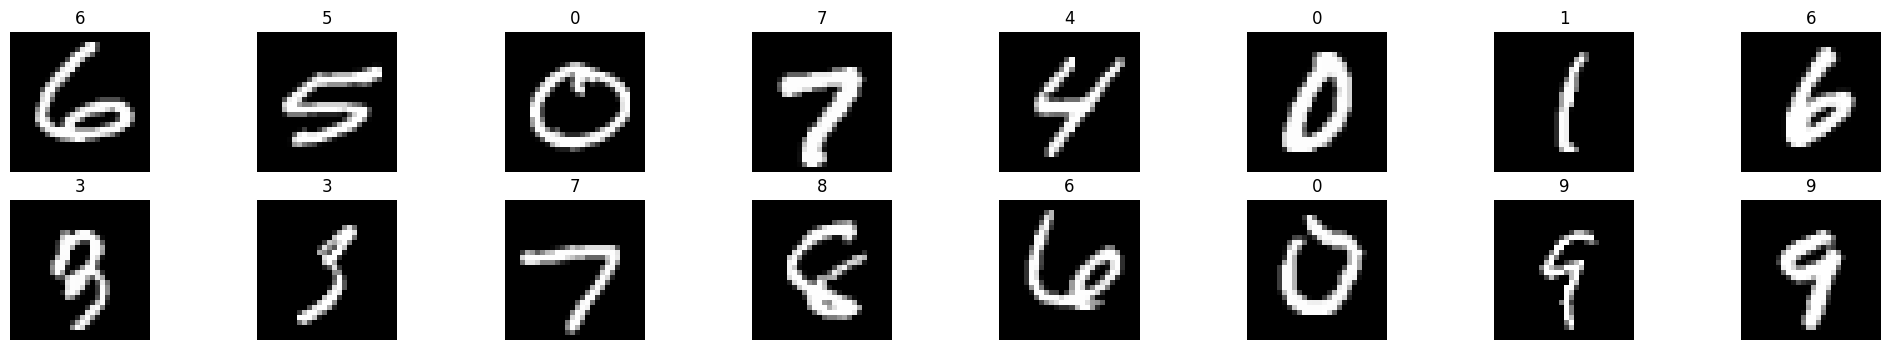

In [4]:
# 查看训练集中的一批样本

import matplotlib.pyplot as plt
%matplotlib inline 

def imshow(img):
    img = img.squeeze()  # 这行代码的作用是挤压（squeeze）掉图像张量中的单通道维度。
                        #   在MNIST数据集中，图像的维度是 (1, 28, 28)，这里挤压之后变成了 (28, 28)，去除了单通道的维度
    plt.imshow(img, cmap='gray')  # cmap='gray' 指定了使用灰度（gray）颜色映射，确保灰度图像以正确的方式显示
    plt.axis('off')
    # 作用是关闭坐标轴的显示。当你调用这个方法时，它将隐藏X和Y轴上的刻度标签和坐标轴线，使得图像呈现出一个纯粹的可视化效果，而不受到坐标轴的干扰
   
dataiter = iter(train_loader) 
images, labels = dataiter.next() 
images = images.numpy() 


fig = plt.figure(figsize=(25, 4)) 
for idx in np.arange(16): 
    ax = fig.add_subplot(2, (int)(16/2), idx+1, xticks=[], yticks=[])  
    imshow(images[idx])
    ax.set_title(classes[labels[idx]]) 


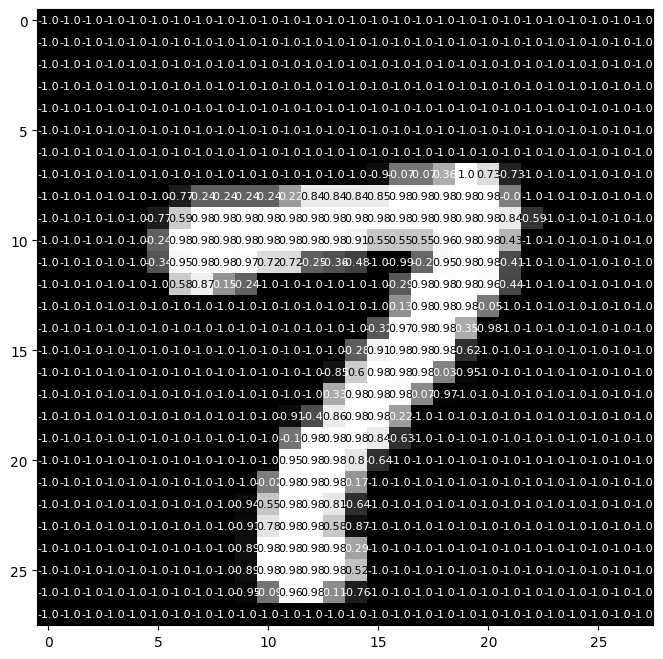

In [5]:
# 查看一张图像中的更多细节,不是必须的

img = np.squeeze(images[3]) 

fig, ax = plt.subplots(figsize=(8, 8)) 
ax.imshow(img,cmap='gray')
width, height = img.shape
thresh = img.max()/2.5  
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0   
        ax.annotate(str(val), xy=(y,x),  
                horizontalalignment='center', 
                verticalalignment='center', size=8,
                color='white' if img[x][y]<thresh else 'black') 
                    


In [6]:
# 定义卷积神经网络的结构



import torch.nn as nn
import torch.nn.functional as F

# 定义卷积神经网络结构
class Net(nn.Module):

    def __init__(self): 
        super(Net, self).__init__() 

        self.conv1 = nn.Conv2d(1, 28, 3, padding=1) 
        self.conv2 = nn.Conv2d(28, 28, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) 

        self.fc1 = nn.Linear(28 * 7 * 7, 500) 
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.3)
        

    # 前向传播
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 28 * 7 * 7) 

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        # x = F.softmax(x, dim=1)
        return x

# 实例化
model = Net()
print(model) 

# # 使用GPU
if train_on_gpu:
    model.cuda() 


Net(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1372, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [7]:
# 选择损失函数与优化函数


import torch.optim as optim
# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()
# 使用随机梯度下降，学习率lr=0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [8]:

###### 训练卷积神经网络模型

n_epochs = 5

valid_loss_min = np.Inf 

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # 训练集的模型 #
    ###################
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad() 

        output = model(data)

        loss = criterion(output, target) 
        loss.backward()

        optimizer.step() 

        train_loss += loss.item()*data.size(0)
        
    ######################    
    # 验证集的模型#
    ######################
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'model_mnist.pt')
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 0.520174 	Validation Loss: 0.137531
Validation loss decreased (inf --> 0.137531).  Saving model ...
Epoch: 2 	Training Loss: 0.139719 	Validation Loss: 0.088864
Validation loss decreased (0.137531 --> 0.088864).  Saving model ...
Epoch: 3 	Training Loss: 0.100841 	Validation Loss: 0.067433
Validation loss decreased (0.088864 --> 0.067433).  Saving model ...
Epoch: 4 	Training Loss: 0.082536 	Validation Loss: 0.062725
Validation loss decreased (0.067433 --> 0.062725).  Saving model ...
Epoch: 5 	Training Loss: 0.069925 	Validation Loss: 0.054028
Validation loss decreased (0.062725 --> 0.054028).  Saving model ...


In [9]:
##### 加载模型

model.load_state_dict(torch.load('model_mnist.pt'))

<All keys matched successfully>

In [10]:
########## 测试训练好的网络


test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()


for data, target in test_loader:
    
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    output = model(data)
    
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    # 记录准确率
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.040175

Test Accuracy of     0: 99% (978/980)
Test Accuracy of     1: 99% (1133/1135)
Test Accuracy of     2: 98% (1014/1032)
Test Accuracy of     3: 98% (993/1010)
Test Accuracy of     4: 98% (972/982)
Test Accuracy of     5: 99% (886/892)
Test Accuracy of     6: 98% (939/958)
Test Accuracy of     7: 97% (1006/1028)
Test Accuracy of     8: 98% (960/974)
Test Accuracy of     9: 97% (984/1009)

Test Accuracy (Overall): 98% (9865/10000)


7


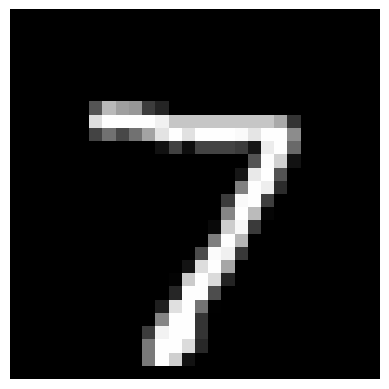

<Figure size 2500x400 with 0 Axes>

In [21]:
########## 显示测试样本的结果


dataiter = iter(test_loader)
images, labels = dataiter.next()
# print(images.size()) # [16,1,28,28],所以模型一次是预测16个图片,也可以只预测一张图片
imshow(images.cpu()[0])
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images.cpu()[0])
# print(output)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
print(preds)

fig = plt.figure(figsize=(25, 4))
# for idx in np.arange(16):
#     ax = fig.add_subplot(2, (int)(16/2), idx+1, xticks=[], yticks=[])
#     imshow(images.cpu()[idx])
#     ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
#                  color=("green" if preds[idx]==labels[idx].item() else "red"))


In [41]:
#################这里导出的模型没有输入和输出

import torch
import torch.onnx
model.eval()

# 创建一个虚拟输入（假设输入大小为28x28）
dummy_input = torch.randn(1, 1, 28, 28)

# 指定ONNX文件的输出路径
onnx_file_path = "mnist_model.onnx"

# 导出模型为ONNX格式
torch.onnx.export(model, dummy_input, onnx_file_path, verbose=True)

Exported graph: graph(%input.1 : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %conv1.weight : Float(28, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %conv1.bias : Float(28, strides=[1], requires_grad=1, device=cpu),
      %conv2.weight : Float(28, 28, 3, 3, strides=[252, 9, 3, 1], requires_grad=1, device=cpu),
      %conv2.bias : Float(28, strides=[1], requires_grad=1, device=cpu),
      %fc1.weight : Float(500, 1372, strides=[1372, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(500, strides=[1], requires_grad=1, device=cpu),
      %fc2.weight : Float(10, 500, strides=[500, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %onnx::Relu_9 : Float(1, 28, 28, 28, strides=[21952, 784, 28, 1], requires_grad=0, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1], onnx_name="Conv_0"](%input.1, %conv1.weight, %con

In [24]:
import torch
import torch.onnx

model.eval()

# 创建一个实际输入
actual_input = torch.randn(1, 1, 28, 28)

# 指定ONNX文件的输出路径
onnx_file_path = "mnist_model.onnx"



# 进行一次推理，获取实际输出
with torch.no_grad():
    actual_output = model(actual_input)
    _, preds_tensor = torch.max(actual_output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    actual_output = preds

# 导出模型为ONNX格式，使用实际输入和输出
torch.onnx.export(model, actual_input, onnx_file_path, verbose=True, input_names=['actual_input'], output_names=['actual_output'])


Exported graph: graph(%actual_input : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %conv1.weight : Float(28, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %conv1.bias : Float(28, strides=[1], requires_grad=1, device=cpu),
      %conv2.weight : Float(28, 28, 3, 3, strides=[252, 9, 3, 1], requires_grad=1, device=cpu),
      %conv2.bias : Float(28, strides=[1], requires_grad=1, device=cpu),
      %fc1.weight : Float(500, 1372, strides=[1372, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(500, strides=[1], requires_grad=1, device=cpu),
      %fc2.weight : Float(10, 500, strides=[500, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %onnx::Relu_9 : Float(1, 28, 28, 28, strides=[21952, 784, 28, 1], requires_grad=0, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[3, 3], pads=[1, 1, 1, 1], strides=[1, 1], onnx_name="Conv_0"](%actual_input, %conv1.we